In [3]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.feature import hog, daisy
import matplotlib.image as mimg
import seaborn as sns
import os
from PIL import Image

In [4]:
"""
    This part reads in all the bmp files into two lists (and then 2 arrays)
    Could be skipped, loading the calculated distance matrix instead
"""
WORKING_DIRECTORY = os.getcwd()+"\dataset"
folder = ""
gallery_data = []
probe_data = []
for path, dirs, files in os.walk(WORKING_DIRECTORY):
    for subdir in dirs:
        folder = os.path.join(path, subdir)
        folder += "\session1"
        for root2, dirs2, files2 in os.walk(folder):
            for file in files2:
                im = mimg.imread(os.path.join(root2, file))
                des, feat = hog(im, orientations=8, visualize=True)
                #arrange features of each template to 180x50 array, for easier Euclidean distance calculation
                gallery_data.append(feat)
for path, dirs, files in os.walk(WORKING_DIRECTORY):
    for subdir in dirs:
        folder = os.path.join(path, subdir)
        folder += "\session2"
        for root2, dirs2, files2 in os.walk(folder):
            for file in files2:
                im = mimg.imread(os.path.join(root2, file))
                des, feat = hog(im, orientations=8, visualize=True)
                #arrange features of each template to 180x50 array, for easier Euclidean distance calculation
                probe_data.append(feat)
print("done")

done


In [5]:
gallery_data = np.array(gallery_data)
probe_data = np.array(probe_data)
gallery_data.shape

(442, 180, 50)

In [6]:
print(gallery_data)

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.55662942 0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.17677669 ... 0.         0.         0.        ]
  [0.         1.42106855 0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

In [7]:
def cal_cosine(vec1, vec2):
    return np.sum(vec1 * vec2) / (np.sqrt(np.sum(vec1**2)) * np.sqrt(np.sum(vec2**2)))


In [8]:
SUBJECTS = 221
TEMPLATES = 221
TEMP_PER_SUB = TEMPLATES//SUBJECTS

In [9]:
"""
    Split the matrix into genuine and imposter groups
"""

def split(mat):
    mat = mat.reshape(SUBJECTS, -1, SUBJECTS)
    mask = np.zeros_like(mat, dtype=np.int32)
    for i in range(SUBJECTS):
        #Only mask = 1 indicates the distance at corresponding position is of 2 same subjects, hence is genuine
        mask[i, :, i] = 1
    return mat[mask == 1], mat[mask == 0]


In [10]:
#BELOW ARE COS DISTANCE
cos_mat= np.zeros((221, 442))
for i in range(len(probe_data)):
    for j in range(len(gallery_data)):
        cos_mat[i,j]=cal_cosine(probe_data[i],gallery_data[j])
best_matching_cos_mat = cos_mat.reshape(-1, SUBJECTS, 2 )
best_matching_cos_mat = best_matching_cos_mat.max(axis=2)
best_matching_cos_mat
dist_garr, dist_iarr = split(best_matching_cos_mat)


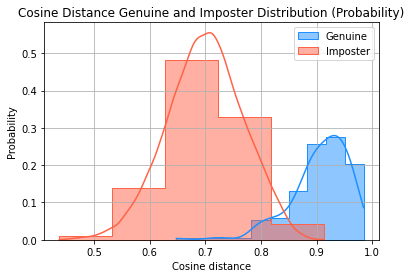

In [11]:
"""
    Requirement 1
    Genuine and Imposter Distribution.
"""
plt.figure(1)
plt.title("Cosine Distance Genuine and Imposter Distribution (Probability)")
plt.xlabel("Cosine distance")
#Set different bin numbers for that the two sets has huge difference in size, i.e., 40050 and 450
sns.histplot(data=dist_garr, kde=True, stat='probability',  bins=10, element='step',color='dodgerblue', label='Genuine')
sns.histplot(data=dist_iarr,  kde=True, stat='probability', bins=5, element='step', color='tomato', label='Imposter')
plt.legend()
plt.grid()
plt.show()


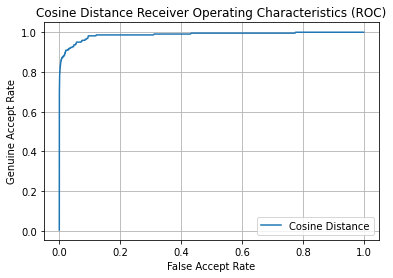

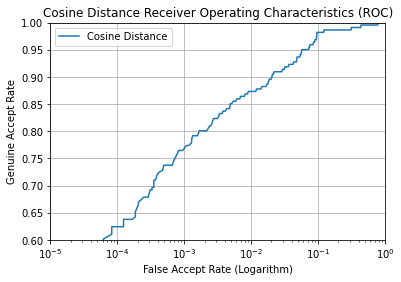

In [12]:
"""
    Requirement 2
    Plot ROC distribution
"""
#Same implementation with lab's, no amendment needed
def cal_far_frr(garr, iarr, resolution=1000):
    d_max = max(garr.max(), iarr.max())
    d_min = min(garr.min(), iarr.min())
    far = np.empty(resolution)
    frr = np.empty(resolution)
    for i, d in enumerate(np.linspace(d_min, d_max, resolution)): #try different thresholds for FAR and FRR
        far[i] = np.sum(iarr > d) / iarr.size
        frr[i] = np.sum(garr < d) / garr.size
    return far, frr

RESOLUTION = 1000
dist_far, dist_frr = cal_far_frr(dist_garr, dist_iarr)

plt.figure(3)
plt.title("Cosine Distance Receiver Operating Characteristics (ROC)")
plt.xlabel("False Accept Rate")
plt.ylabel("Genuine Accept Rate")
plt.plot(dist_far, 1-dist_frr, label="Cosine Distance")
plt.legend()
plt.grid()
plt.show()

plt.figure(4)
plt.title("Cosine Distance Receiver Operating Characteristics (ROC)")
plt.xlabel("False Accept Rate (Logarithm)")
plt.ylabel("Genuine Accept Rate")
plt.xscale('log')
plt.xlim([1e-5, 1])
plt.ylim([0.6, 1.0])
plt.plot(dist_far, 1-dist_frr, label="Cosine Distance")
plt.legend()
plt.grid()
plt.show()

In [13]:
"""
    Requirement 3: Equal Error Rate and Decidability Index
"""
def cal_eer(far, frr):
    #calculate when FAR=FRR
    index = np.argmin(np.abs(far - frr))
    return index, far[index]
eer_index, dist_eer = cal_eer(dist_far, dist_frr)
print("EER using Cosine distance = %.2f%%" % (dist_eer * 100))

def cal_decidability_index(garr, iarr):
    g_mean = garr.mean()
    i_mean = iarr.mean()
    g_var = garr.var()#no need to use standard deviation, variance is more convenient
    i_var = iarr.var()
    return abs(g_mean - i_mean)/np.sqrt((g_var+i_var)/2)
print("Decidability index using Cosine distance = %.2f" % cal_decidability_index(dist_garr, dist_iarr))

EER using Cosine distance = 5.58%
Decidability index using Cosine distance = 3.38


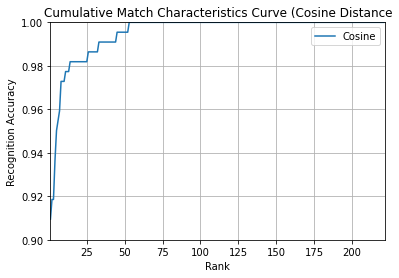

In [14]:
"""
    Requirement 4: Plot Cumulative Match Characteristics
"""
#array, at index i stores the top-i error count (i.e., cannot find correct subject with i highest matches)
topn_error_count = np.zeros(SUBJECTS, dtype=np.int16)

for row_idx, row in enumerate(best_matching_cos_mat):
    #sort the distance row of this template, return the indices
    sorted_index = np.argsort(-row)
    #iterate from highest match to lowest
    for idx_idx, idx in enumerate(sorted_index):
         #if the subject this row belongs to is the same as the subject referred to by the index of current match
        if row_idx//TEMP_PER_SUB == idx:
            #former matches are all error and later are all success
            topn_error_count[:idx_idx]+=1
            break
dist_cmc = 1-topn_error_count/TEMPLATES

plot_range = SUBJECTS
plt.plot(range(1, plot_range+1), dist_cmc[:plot_range], label="Cosine")
plt.title("Cumulative Match Characteristics Curve (Cosine Distance")
plt.xlabel("Rank")
plt.ylabel("Recognition Accuracy")
plt.xlim((1, plot_range+1))
plt.ylim((.9, 1))
plt.grid()
plt.legend()
plt.show()

(180, 1)


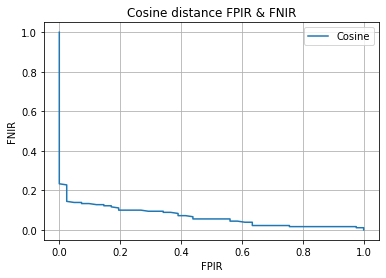

In [15]:
"""
    Requirement 5:
    Plot False Negative Identification Rate (FNIR) against False Positive Identification Rate (FPIR)
    Using the best match matrix rather than full 450x450 matrix is enough
"""
REGISTERED = 180
UNREGISTERED = 41

#Get the distance matrix of that between only registered subjects and themselves(70 subjects, each has 5 distance values)
registered_dist_mat = best_matching_cos_mat[:REGISTERED*TEMP_PER_SUB, :REGISTERED]
registered_identity_dist_mat = np.asarray([registered_dist_mat[TEMP_PER_SUB*i:TEMP_PER_SUB*i+TEMP_PER_SUB, i] for i in range(0, REGISTERED)])
print(registered_identity_dist_mat.shape)
#Get the distance matrix of that between registered and unregistered subjects
unregistered_dist_mat = best_matching_cos_mat[REGISTERED*TEMP_PER_SUB:, :REGISTERED]

dist_fpir = np.empty(RESOLUTION)
dist_fnir = np.empty(RESOLUTION)
t_min, t_max = min(registered_dist_mat.min(), unregistered_dist_mat.min()), max(registered_dist_mat.max(), unregistered_dist_mat.max())

#Try different thresholds for FNIR and FPIR calculation
for i, t in enumerate(np.linspace(t_min, t_max, RESOLUTION)):
    #Summing up the negative cases in the distance matrix of only registered subjects
    dist_fnir[i] = np.sum(registered_identity_dist_mat<=t)/(TEMP_PER_SUB*REGISTERED)
    #Summing up the rows that have positive cases in the distance matrix of that between registered and unregistered subjects
    dist_fpir[i] = np.sum(np.sum(unregistered_dist_mat>t, axis=1)>=1)/(TEMP_PER_SUB*UNREGISTERED)

plt.title("Cosine distance FPIR & FNIR")
plt.xlabel("FPIR")
plt.ylabel("FNIR")
plt.plot(dist_fpir, dist_fnir, label="Cosine")
plt.grid()
plt.legend()